# Lagrangian Kinematic Model
@author: Max Felius

The goal is to plot 3D space with n number of points. Each point has 3 coordinates (x,y,z) which are each influenced by a forming sinkhole. Over time, the points move horizontally and vertically through space.

Types of sinkhole forming effects present:
- subsurface cavity rising
- stoping (suffosion)

## Roadmap

- Create 3D space of points. Each point has [x,y,z] component

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import mpld3
from matplotlib.widgets import Slider, Button, RadioButtons

In [2]:
#Sinkhole object
class sinkhole_function:
    def __init__(self,x0,y0,H,M,w,draw,x_range,y_range,nx):
        self.x0 = x0
        self.y0 = y0
        self.H = H
        self.M = M
        self.w = w
        self.draw = draw
        self.R = self.H*np.tan(self.draw)
        self.wc = self.H/np.cos(self.draw)
        self.S = (2*self.M*self.w)/(self.w + self.wc)

        self.x_range = x_range
        self.y_range = y_range
        
    def reset_sinkhole(self,H_in):
        self.H = H_in
        self.R = self.H*np.tan(self.draw)
        self.wc = self.H/np.cos(self.draw)
        self.S = (2*self.M*self.w)/(self.w + self.wc)
        
    def reset_subsidence(self,M_in,H_in):
        self.M = M_in
        self.H = H_in
        self.S = (2*self.M*self.w)/(self.w + self.wc)

In [3]:
#epicenter sinkhole
x0 = 25
y0 = 25

# number of points
nx = 20

# range
x_range = 15 # meters (around center)
y_range = 15 # meters (around center)

x = np.linspace(x0-x_range/2, x0+x_range/2, nx)
y = np.linspace(y0-y_range/2,y0+y_range/2, nx)

#Define Sinkhole parameters
w = 5 #[m], width of the cavity
H = 10 #[m], depth/height of the cavity
draw = 35 * (np.pi/180) #[rad], angle of draw
M = 4 #[m], cavity height

R    = H*np.tan(draw)  # [m]
wc   = H/np.cos(draw)  # [m]
S    = (2*M*w)/(w + wc) #[m], max subsidence

xv, yv = np.meshgrid(x, y)

#start at ground level
zv = np.zeros((nx,nx))

#Create 1D vectors for plotting efficiency
x_unravel = np.ravel(xv)
y_unravel = np.ravel(yv)
z_unravel = np.ravel(zv)

# Create sinkhole object
sinkhole_obj = sinkhole_function(x0,y0,H,M,w,draw,x_range,y_range,nx)

In [4]:
#create 3D space - Redundant
#layer contain the 3d vectors per point
p = np.array([[[xj,yj,zv[j,i]] for i,xj in enumerate(x)] for j,yj in enumerate(y)])

In [ ]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x_unravel , y_unravel , z_unravel , color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [5]:
def zg(x,x0,y,y0,R,S):
    return -(S/(R*R))*np.exp(-np.pi * ((x-x0)**2 + (y-y0)**2)/R**2)

def xhdisp(x,x0,y,y0,R,S,H):
    s = zg(x,x0,y,y0,R,S)
    return s * ((x-x0)/H)

def yhdisp(x,x0,y,y0,R,S,H):
    s = zg(x,x0,y,y0,R,S)
    return s * ((y-y0)/H) 

In [6]:
def time_function(t,time_type,t0=0,a=1,b=1):
    '''
    Time function to manage the speed of the suffosion or stopig simulation
    
    type t: list/np array
    type time_type: string
    type t0: int
    type a: int
    type b: int
    
    rtype: np array
    '''
    def type_time_function(t,t0,a,b,mode):
        if t-t0 <= 0:
            return 0
        else:
            if mode == 'linear':
                return a*(t-t0)
            elif mode == 'poly':
                return a*(t-t0)**2 + b*(t-t0)
            elif mode == 'exp':
                return a*np.exp((t-t0))
            elif mode == 'log':
                return a*np.log(1+b*(t-t0))
            else:
                print('No mode selected')
                return 0

    return np.array([type_time_function(x,t0,a,b,time_type) for x in t])

def suffosion(sinkhole,x_in,y_in,z_in,t,time_type):
    '''
    Suffosion sinkhole simulator
    
    Cavity increases in size going upwards
    
    Input:
    type sinkhole: sinkhole_function object
    type x,y,z: (nx1) array
    type t: (mx1) array 
    type: time_type: string
    
    Output:
    rtype x,y,z: (nxm) array
    '''            
    # Per time step, a new column of x,y,z should be added. 
    # New positional values for x,y,z are calculated by combining the influence function and the time function
    
    M = sinkhole.M
    w = sinkhole.w
    wc = sinkhole.wc
    R = sinkhole.R
    H_start = sinkhole.H
    H_end = 3
    
    a = 1
    b = 1
    
    t_out = time_function(t,time_type,t0=0,a=1,b=1)

    #normalize output
    t_out = t_out/max(t_out)
    
    #predefine output matrix
    x_out = np.zeros((len(x_in),1+len(t_out)))
    y_out = np.zeros((len(x_in),1+len(t_out)))
    z_out = np.zeros((len(x_in),1+len(t_out)))
    
    #copy input
    x_out[:,0] = x_in
    y_out[:,0] = y_in
    z_out[:,0] = z_in
    
    for idx,ti in enumerate(t_out):
        Hi = H_start-ti*(H_start-H_end)
        Mi = M+ti*(H_start-H_end)
        Ri = Hi*np.tan(np.deg2rad(35))
        
        Si = (2*Mi*w)/(w + wc) #[m], max subsidence

        # Vertical Displacement
        sz = zg(x_in,sinkhole.x0,y_in,sinkhole.y0,Ri,Si)

        # Horizontal Displacement x-direction
        sx = xhdisp(x_in,sinkhole.x0,y_in,sinkhole.y0,Ri,Si,Hi)

        # Horizontal Displacement y-direction
        sy = yhdisp(x_in,sinkhole.x0,y_in,sinkhole.y0,Ri,Si,Hi)
        
        x_out[:,idx+1] = x_out[:,idx] + sx 
        y_out[:,idx+1] = y_out[:,idx] + sy
        z_out[:,idx+1] = z_out[:,idx] + sz 
    
    return x_out, y_out, z_out
    
def stoping():
    '''
    Stoping simulator
    
    Cavity migrate upwards but doesn't change in size
    '''
    pass

In [7]:
def create_cavity_position(x0,y0,t,sinkhole,mechanism,time_type):
    '''
    '''
    if mechanism.lower() == 'suffosion':
        #middle point
        x_m = x0
        y_m = y0
        z_m = sinkhole.H
        w = sinkhole.w
        M = sinkhole.M

        H_start = sinkhole.H
        H_end = 3
        
        t_out = time_function(t,time_type,t0=0,a=1,b=1)
        
        #normalize output
        t_out = t_out/max(t_out)
        
        #pre-allocate space
        b1 = np.zeros((1+len(t_out),3))
        b2 = np.zeros((1+len(t_out),3))
        b3 = np.zeros((1+len(t_out),3))
        b4 = np.zeros((1+len(t_out),3))
         
        t1 = np.zeros((1+len(t_out),3))
        t2 = np.zeros((1+len(t_out),3))
        t3 = np.zeros((1+len(t_out),3))
        t4 = np.zeros((1+len(t_out),3))
        
        #bottom
        b1[0,:] = np.array([x0-0.5*w,y0-0.5*w,-H_start-0.5*M])
        b2[0,:] = np.array([x0+0.5*w,y0-0.5*w,-H_start-0.5*M])
        b3[0,:] = np.array([x0+0.5*w,y0+0.5*w,-H_start-0.5*M])
        b4[0,:] = np.array([x0-0.5*w,y0+0.5*w,-H_start-0.5*M])

        #top
        t1[0,:] = np.array([x0-0.5*w,y0-0.5*w,-H_start+0.5*M])
        t2[0,:] = np.array([x0+0.5*w,y0-0.5*w,-H_start+0.5*M])
        t3[0,:] = np.array([x0+0.5*w,y0+0.5*w,-H_start+0.5*M])
        t4[0,:] = np.array([x0-0.5*w,y0+0.5*w,-H_start+0.5*M])
        
        for idx,ti in enumerate(t_out):
            
            #Get new cavity parameters
            Hi = H_start-ti*(H_start-H_end)
            Mi = M+ti*(H_start-H_end)
            Ri = Hi*np.tan(np.deg2rad(35))
            
            #bottom
            b1[idx+1,:] = np.array([x0-0.5*w,y0-0.5*w,-H_start-0.5*M])
            b2[idx+1,:] = np.array([x0+0.5*w,y0-0.5*w,-H_start-0.5*M])
            b3[idx+1,:] = np.array([x0+0.5*w,y0+0.5*w,-H_start-0.5*M])
            b4[idx+1,:] = np.array([x0-0.5*w,y0+0.5*w,-H_start-0.5*M])

            #top
            t1[idx+1,:] = np.array([x0-0.5*w,y0-0.5*w,-Hi+0.5*M])
            t2[idx+1,:] = np.array([x0+0.5*w,y0-0.5*w,-Hi+0.5*M])
            t3[idx+1,:] = np.array([x0+0.5*w,y0+0.5*w,-Hi+0.5*M])
            t4[idx+1,:] = np.array([x0-0.5*w,y0+0.5*w,-Hi+0.5*M])

        plot_box = np.array([b1,b2,b3,b4,b1,t1,t2,t3,t4,t1,b1,b4,t4,t3,b3,b2,t2])

        #output shape: (17,len(t_out),3)
        return plot_box
    
    elif mechanism.lower() == 'stoping':
        print('Not built yet')
    
    else:
        print('No Mechanism Specified. Please specify a mechanism')

## Example Figure

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline

plot_box = create_cavity_position(x0,y0,[x for x in range(10)],sinkhole_obj,'suffosion','linear')
x_new, y_new, z_new = suffosion(sinkhole_obj,x_unravel,y_unravel,z_unravel,[x for x in range(10)],'linear')

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

number = 2

# Creating plot
ax.scatter3D(x_new[:,1] , y_new[:,number] , z_new[:,number] , c=z_new[:,number])#x_new[:,number]-x_new[:,0])
ax.plot3D(plot_box[:,number,0],plot_box[:,number,1],plot_box[:,number,2])#, color = "red")

plt.title("simple 3D scatter plot")
ax.set_xlabel('x-direction [-]')
ax.set_ylabel('y-direction [-]')
ax.set_zlabel('z-direction [-]')

plt.show()

## Creating the seperate figure plots for the gif

In [ ]:
time_vector = [x for x in range(9)]

x_new, y_new, z_new = suffosion(sinkhole_obj,x_unravel,y_unravel,z_unravel,time_vector,'linear')
plot_box = create_cavity_position(x0,y0,time_vector,sinkhole_obj,'suffosion','linear')
 
# %matplotlib notebook
%matplotlib inline

zmax = min(plot_box[:,0,2])

#remove all png files from folder
files = sorted(os.listdir('images'))

for file_name in files:
    if file_name.endswith('.png'):
        os.remove(os.path.join('images',file_name))

for number in range(1,x_new.shape[1]):
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(x_new[:,number] , y_new[:,number] , z_new[:,number] , c=z_new[:,-1])
    ax.plot3D(plot_box[:,number,0],plot_box[:,number,1],plot_box[:,number,2])#, color = "red")

    plt.title("simple 3D scatter plot")
    ax.set_xlabel('x-direction [-]')
    ax.set_ylabel('y-direction [-]')
    ax.set_zlabel('z-direction [-]')
    ax.set_zlim3d(zmax,0)
    
    fig.savefig(f'images/3dscatter_sinkhole_n{number}.png')
    plt.close(fig)
# show plot
# plt.show()
print('Done')

## Show Pannable figure

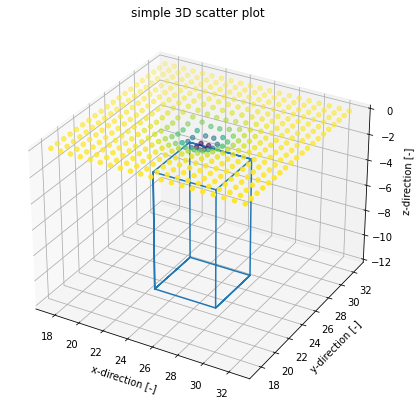

In [8]:
# %matplotlib notebook
# %matplotlib inline

time_vector = [x for x in range(9)]

x_new, y_new, z_new = suffosion(sinkhole_obj,x_unravel,y_unravel,z_unravel,time_vector,'linear')
plot_box = create_cavity_position(x0,y0,time_vector,sinkhole_obj,'suffosion','linear')

zmax = min(plot_box[:,0,2])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

number = 7

# Creating plot
ax.scatter3D(x_new[:,number] , y_new[:,number] , z_new[:,number] , c=z_new[:,-1])
ax.plot3D(plot_box[:,number,0],plot_box[:,number,1],plot_box[:,number,2])#, color = "red")

plt.title("simple 3D scatter plot")
ax.set_xlabel('x-direction [-]')
ax.set_ylabel('y-direction [-]')
ax.set_zlabel('z-direction [-]')
ax.set_zlim3d(zmax,0)

plt.show()

## Create gif image

In [ ]:
import imageio

images = []

files = sorted(os.listdir('images'))

for file_name in files:
    if file_name.endswith('.png'):
        file_path = os.path.join('images',file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(os.path.join('images','sinkhole_animation.gif'),images,fps=1)

print('Done')


![](images/sinkhole_animation.gif)

## Visualization using matplotlib

In [7]:
%matplotlib qt5

#source: https://matplotlib.org/3.1.1/gallery/widgets/slider_demo.html
time_vector = [x for x in range(9)]

x_new, y_new, z_new = suffosion(sinkhole_obj,x_unravel,y_unravel,z_unravel,time_vector,'linear')
plot_box = create_cavity_position(x0,y0,time_vector,sinkhole_obj,'suffosion','linear')

zmax = min(plot_box[:,0,2])

fig, ax = plt.subplots(figsize = (10, 7))
plt.subplots_adjust(bottom=0.25)
ax = plt.axes(projection ="3d")
ax.set_xlabel('Distance East [m]')
ax.set_ylabel('Distance North [m]')
ax.set_zlabel('Distance Up [m]')
ax.set_zlim(min(plot_box[:,-1,2]),0.1)
ax.set_title(f'Time step: {0}')

# Creating initial plot
number = 0
p = ax.scatter3D(x_new[:,number] , y_new[:,number] , z_new[:,number] , c=z_new[:,-1])
ax.plot3D(plot_box[:,number,0],plot_box[:,number,1],plot_box[:,number,2])
fig.colorbar(p)

ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
axtime = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)

stime = Slider(axtime, 'Time', 0, len(time_vector)-1, valinit=0, valstep=1)

def update(val):
    ax.clear()
    num = int(np.round(val))

    #create new plot
    ax.scatter3D(x_new[:,num] , y_new[:,num] , z_new[:,num] , c=z_new[:,-1])
    ax.plot3D(plot_box[:,num,0],plot_box[:,num,1],plot_box[:,num,2])
    ax.set_xlabel('Distance East [m]')
    ax.set_ylabel('Distance North [m]')
    ax.set_zlabel('Distance Up [m]')
    ax.set_zlim(min(plot_box[:,-1,2]),0.1)
    ax.set_title(f'Time step: {num}')
    fig.canvas.draw_idle()


stime.on_changed(update)
# samp.on_changed(update)

# resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
# button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


# def reset(event):
#     sfreq.reset()
#     samp.reset()
# button.on_clicked(reset)

# rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
# radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


# def colorfunc(label):
#     l.set_color(label)
#     fig.canvas.draw_idle()
# radio.on_clicked(colorfunc)

plt.show()